In [2]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [3]:
channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "SARES11-LSCP10-FNS:CH0:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_position = "SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position

In [4]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = pulse_ids%4 == 0                         #This is for 25 Hz
        reprate_laser = pulse_ids%2 == 0                     #This is for 50 Hz  
        
        Data = BS_file[channel_LaserDiode][:][reprate_laser]
        Izero = BS_file[channel_Laser_refDiode][:][reprate_laser]
        Position = BS_file[channel_position][:][reprate_laser]
        
    return Data, Izero, Position

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [5]:
DIR = "/sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/"
DIR_json = "/sf/alvra/data/p17569/res/scan_info/"

!ls -lah -rt /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 226M
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0000.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0001.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0002.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0003.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0004.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0005.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0006.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0007.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:43 Laser_knife_edge_X_004_step0008.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:44 Laser_knife_edge_X_004_step0009.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:44 Laser_knife_edge_X_004_step0010.h5
-rw-r--r--.   1 root  p17569 5.5M Dec 10 21:44 Laser_knife_edge_X_004_step0011.h5
-rw-r

In [6]:
scan_name ="Laser_knife_edge_X_004"

json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Signal = []
err_signal = []

Izero = []
err_Izero = []

Position_mm = []

for i in range(0,numFiles):
    print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
    (signal_loop,Izero_loop,position_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
    Signal.append(signal_loop.mean())
    err_signal.append(signal_loop.std()/np.sqrt(signal_loop.size))
    Izero.append(Izero_loop.mean())
    err_Izero.append(Izero_loop.std()/np.sqrt(Izero_loop.size))

    Position_mm.append(position_loop.mean())
    
Signal = np.asarray(Signal)
err_signal = np.asarray(err_signal)
Izero = np.asarray(Izero)
err_Izero = np.asarray(err_Izero)

Position_mm = np.asarray(Position_mm)

/sf/alvra/data/p17569/res/scan_info/Laser_knife_edge_X_004_scan_info.json
Processing 41 files
step 1 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0000.h5
step 2 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0001.h5
step 3 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0002.h5
step 4 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0003.h5
step 5 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0004.h5
step 6 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0005.h5
step 7 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Laser_knife_edge_X_004/Laser_knife_edge_X_004_step0006.h5
step 8 of 41 : Processing /sf/alvra/data/p17569/res/scan_data/Lase

In [7]:
Signal_norm = Signal / Izero
err_signal_norm = err_signal / Izero

<IPython.core.display.Javascript object>


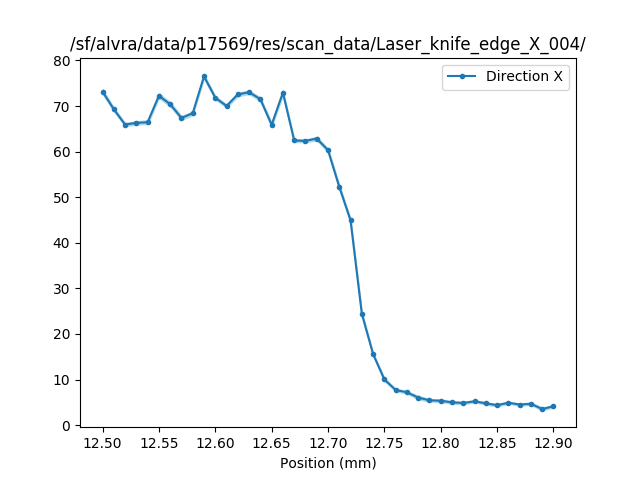

In [8]:
plt.figure()

plt.plot(Position_mm, Signal_norm, label="Direction X",marker='.')

low_err= Signal_norm - err_signal_norm
high_err= Signal_norm + err_signal_norm

plt.fill_between(Position_mm, low_err, high_err, color='lightblue')
plt.title(DIR)
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig('Timescan_7_diode')

In [10]:
# Now fit with error funciton (defined above)
parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [70, 0.1, 12.7, 0.05])

print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = 12.722 mm
Width = 0.025 mm


<IPython.core.display.Javascript object>


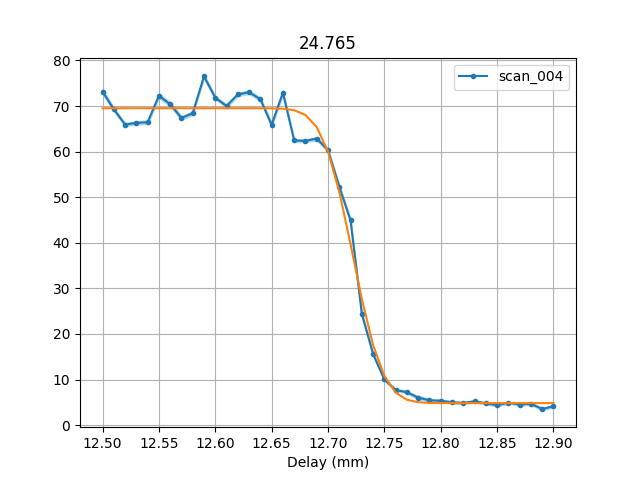

In [17]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Position_mm, Signal_norm, label="scan_004",marker='.')
plt.plot(Position_mm, errfunc(Position_mm,*parameters))

low_err= Signal_norm - err_signal_norm
high_err= Signal_norm + err_signal_norm
plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

plt.title(np.round(parameters[3]*1000, 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_LAM_003')